In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
import random
import pickle
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

2023-06-08 23:27:38.580253: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-08 23:27:38.582932: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 23:27:38.623565: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 23:27:38.624482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 23:27:39.771568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
def get_targets_with_weights(batch_data, initial_ensembles, size_ens, ann): 
    
    target_dim = 1
    
    weights_ann_1 = ann.get_weights()
    
    h1  = ann.layers[1].output.shape[-1]

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [3]:
def ann(hidden = 32, input_shape = 256, output_shape = 1): 
    input_layer = tf.keras.layers.Input(shape = (input_shape))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(output_shape, activation = "relu")
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [4]:
def generate_initial_ensembles(num_weights, lambda1, size_ens):
    mean_vec = np.zeros((num_weights,))
    cov_matrix = lambda1*np.identity(num_weights)
    mvn_samp = mvn(mean_vec, cov_matrix)
    return mvn_samp.rvs(size_ens)

In [5]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [6]:
def get_initial_X_t(data1, data2, size_ens):
    samp_ann =  ann(hidden = 16, input_shape = 32, output_shape = 1)
    
    initial_ensembles1 = generate_initial_ensembles(samp_ann.count_params(), 1, size_ens)
    data1_out1, data1_stack1 = get_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens, ann = samp_ann)
    
    initial_ensembles2 = generate_initial_ensembles(samp_ann.count_params(), 1, size_ens)
    data1_out2, data1_stack2 = get_targets_with_weights(data1, initial_ensembles2, size_ens = size_ens, ann = samp_ann)
    
    initial_ensembles3 = generate_initial_ensembles(samp_ann.count_params(), 1, size_ens)
    data2_out1, data2_stack1 = get_targets_with_weights(data2, initial_ensembles3, size_ens = size_ens, ann = samp_ann)
    
    initial_ensembles4 = generate_initial_ensembles(samp_ann.count_params(), 1, size_ens)
    data2_out2, data2_stack2 = get_targets_with_weights(data2, initial_ensembles4, size_ens = size_ens, ann = samp_ann)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles_for_weights = generate_initial_ensembles(4, 1, size_ens)
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # print(X_t.shape, initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights), axis = 1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4))
    
    return X_t, initial_ensembles, initial_ensembles_for_weights[:,0,:]

In [7]:
def get_weighted_targets_with_weights(batch_data, initial_ensembles, size_ens, ann, weights): 
    
    target_dim = 1
    
    weights_ann_1 = ann.get_weights()
    
    h1  = ann.layers[1].output.shape[-1]

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    final_output_1 = final_output_1*weights
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [8]:
alogp_bottleneck = np.load("..//Data/small_mol_phase_3_features_for_both.npy")

In [9]:
# y_valid

In [10]:
y_valid = pd.read_csv("..//Data/smiles_with_rdkit_with_small_phase_3_outputs.csv")

In [11]:
# y_valid

In [12]:
std_targets = pickle.load( open('..//Data//target_scaler.pkl', 'rb'))

/home/statgrads/vpiyush2/.conda/envs/enkf/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [13]:
# y_valid

In [14]:
y_train = y_valid.values[:,1:]

In [15]:
y_train = std_targets.transform(y_train)

/home/statgrads/vpiyush2/.conda/envs/enkf/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
x_train, x_valid, y_train, y_valid = train_test_split(alogp_bottleneck, y_train, test_size = 0.25, shuffle = True, 
                                                     random_state = 42)

In [18]:
x_train.shape

(719, 64)

In [19]:
R_t = np.cov(y_train.T)

In [20]:
R_t

array([[ 2.00883439, -0.73234091],
       [-0.73234091,  1.65672997]])

In [21]:
var1 = R_t[0,0]
var2 = R_t[1,1]
cov = R_t[1,0]

In [22]:
ul = var1*np.identity(x_train.shape[0])
lr = var2*np.identity(x_train.shape[0])
ur = cov*np.identity(x_train.shape[0])
ll = ur.T

In [23]:
first_row = np.hstack((ul, ur))
second_row = np.hstack((ll, lr))

In [24]:
first_row.shape

(719, 1438)

In [25]:
second_row.shape

(719, 1438)

In [26]:
R_t = np.vstack((first_row, second_row))

In [27]:
R_t.shape

(1438, 1438)

In [28]:
smiles_feats_train = x_train[:, :32]

In [29]:
rdkit_feats_train = x_train[:, 32:]

In [30]:
smiles_feats_valid = x_valid[:, :32]
rdkit_feats_valid = x_valid[:, 32:]

In [31]:
# size_ens = 250

In [32]:
# X_t, initial_ensembles, initial_ensembles_for_weights = get_initial_X_t(smiles_feats_train, rdkit_feats_train, size_ens = size_ens)

In [33]:
# initial_ensembles_for_weights.shape

In [34]:
# initial_ensembles.shape

In [35]:
# initial_ensembles = np.hstack((initial_ensembles, initial_ensembles_for_weights))

In [36]:
# initial_ensembles.shape

In [37]:
def forward_operation(data1, data2, combined_ensembles , size_ens ):
    samp_ann =  ann(hidden = 16, input_shape = 32, output_shape = 1)
    params = samp_ann.count_params()
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (4*params):]
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:,:2].sum(1).reshape(-1,1)
    
    model_2 = softmax_weights[:,2:].sum(1).reshape(-1,1)
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                 ann = samp_ann, weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data1, initial_ensembles2, size_ens = size_ens,
                                                                 ann = samp_ann, weights=model_1)
    
    data2_out1, data2_stack1 = get_weighted_targets_with_weights(data2, initial_ensembles3, size_ens = size_ens,
                                                                 ann = samp_ann, weights=model_2)
    
    data2_out2, data2_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles4, size_ens = size_ens,
                                                                 ann = samp_ann, weights=model_2)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4, 
                        initial_ensembles_for_weights))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights), axis = 1)
    
    weighted_alogp = data1_out1 + data2_out1
    
    weighted_psa = data1_out2 + data2_out2
    
    return X_t, initial_ensembles, weighted_alogp, weighted_psa

In [38]:
samp_ann =  ann(hidden = 16, input_shape = 32, output_shape = 1)

2023-06-08 23:27:41.825376: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-08 23:27:41.825410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: c3101.swan.hcc.unl.edu
2023-06-08 23:27:41.825419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: c3101.swan.hcc.unl.edu
2023-06-08 23:27:41.825546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.85.5
2023-06-08 23:27:41.825567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.85.5
2023-06-08 23:27:41.825573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.85.5


In [39]:
total_weights = samp_ann.count_params()*4 + 4

In [40]:
reduction = 8

In [41]:
size_ens = total_weights//reduction

In [42]:
size_ens

273

In [43]:
X_t, initial_ensembles, initial_ensembles_for_weights = get_initial_X_t(smiles_feats_train, rdkit_feats_train, size_ens = size_ens)

In [44]:
initial_ensembles = np.hstack((initial_ensembles, initial_ensembles_for_weights))

In [45]:
# X_t, initial_ensembles, weighted_alogp, weighted_psa = forward_operation(smiles_feats_train, rdkit_feats_train, combined_ensembles = initial_ensembles, size_ens = size_ens)

In [46]:
# chk = get_predictions(smiles_feats_train, rdkit_feats_train, initial_ensembles)

In [47]:
# chk.shape

In [48]:
# catch = Parallel(n_jobs = 15, verbose = 0)(delayed(inverse_transform)(chk, i)  for i in range(chk.shape[0]))

In [49]:
# np.array(catch).shape

In [50]:
def get_predictions(data1, data2, initial_ensembles): 
    _,_, weighted_alogp, weighted_psa = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens)
    weighted_alogp = np.expand_dims(weighted_alogp,-1)
    weighted_psa = np.expand_dims(weighted_psa,-1)
    preds = np.concatenate((weighted_alogp, weighted_psa),-1)
    return preds

In [51]:
def calculate_mu_bar_G_bar(data1, data2, initial_ensembles):
    mu_bar = initial_ensembles.mean(0)
    _,_, weighted_alogp, weighted_psa = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens)
    weighted_alogp = np.expand_dims(weighted_alogp,-1)
    weighted_psa = np.expand_dims(weighted_psa,-1)
    G_u = np.concatenate((weighted_alogp, weighted_psa), axis = -1)
    G_u = G_u.transpose((0,2,1))
    G_u = G_u.reshape(G_u.shape[0], G_u.shape[1]*G_u.shape[2])
    # G_u
    G_bar = (G_u.mean(0)).ravel()
    return mu_bar.reshape(-1,1), G_bar.reshape(-1,1), G_u

In [52]:
# mu_bar, G_bar, G_u = calculate_mu_bar_G_bar(smiles_feats_train, rdkit_feats_train, initial_ensembles)

In [53]:
# mu_bar.shape

In [54]:
# G_bar.shape

In [55]:
# G_u.shape

In [56]:
def calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u): 
    u_j_minus_u_bar = initial_ensembles - mu_bar.reshape(1,-1)
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    c = np.zeros((total_weights, G_bar.shape[0]))
    for i in range(0, size_ens): 
        c += np.kron(u_j_minus_u_bar[i, :].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return c/size_ens, G_u_minus_G_bar

In [57]:
def calculate_D_u( G_bar, G_u): 
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    d = np.zeros((G_bar.shape[0], G_bar.shape[0]))
    for i in range(0, size_ens): 
        d += np.kron(G_u_minus_G_bar[i,:].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return d/size_ens

In [58]:
def get_updated_ensemble(data1, data2, initial_ensembles):
    mu_bar, G_bar, G_u = calculate_mu_bar_G_bar(data1, data2, initial_ensembles)
    C, G_u_minus_G_bar = calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u)
    D = calculate_D_u( G_bar, G_u)
    mid_quant = C@np.linalg.inv(D + lambda_inv)
    right_quant = y_train.T.flatten().reshape(-1,1) - G_u.T
    mid_times_right = mid_quant@right_quant
    updated_ensemble = (initial_ensembles.T + mid_times_right)
    return updated_ensemble.T

In [59]:
target_dim = 2

In [60]:
lambda_D = 1

In [61]:
# u_bar, G_bar, G_u = calculate_mu_bar_G_bar(smiles_feats_train, rdkit_feats_train, initial_ensembles)

In [62]:
# G_bar.shape

In [63]:
# lambda_inv = np.linalg.inv(lambda_D*np.identity(G_bar.shape[0]))
lambda_inv = np.linalg.inv(R_t)

In [64]:
lambda_inv.shape

(1438, 1438)

In [65]:
# G_u.shape

In [66]:
def inverse_transform(data, idx):
    data_cur = data[idx, :, :]
    inv_data_cur = std_targets.inverse_transform(data_cur)
    return inv_data_cur

In [67]:
from joblib import Parallel, delayed

In [68]:
# catch = Parallel(n_jobs = 15, verbose = 3)(delayed(inverse_transform)(G_u_test, i)  for i in range(G_u_test.shape[0]))

In [69]:
# G_u_train.shape

In [70]:
for i in range(0,10000):
    
    initial_ensembles = get_updated_ensemble(smiles_feats_train, rdkit_feats_train, initial_ensembles)
    G_u_train = get_predictions(smiles_feats_train, rdkit_feats_train, initial_ensembles)
    # G_u_train = get_targets_with_weights(smiles_feats_train, rdkit_feats_train, initial_ensembles, size_ens = size_ens)
    catch = Parallel(n_jobs = 15, verbose = 0)(delayed(inverse_transform)(G_u_train, i)  for i in range(G_u_train.shape[0]))
    G_u_train = np.array(catch)
    
    y_train_cur = std_targets.inverse_transform(y_train)
    
    li_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[0,:,:]   
    ui_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[1,:,:]
    
    width_train = ui_train - li_train
    avg_width_train = width_train.mean(0)
    
    ind_train = (y_train_cur >= li_train) & (y_train_cur <= ui_train)
    coverage_train= ind_train.mean(0)
    
    averaged_targets_train = G_u_train.mean(0)
    rmse_train = np.sqrt(((y_train_cur -averaged_targets_train)**2).mean(0))
    print(rmse_train, coverage_train, avg_width_train)
    
    G_u_test = get_predictions(smiles_feats_valid, rdkit_feats_valid, initial_ensembles)
    
    catch = Parallel(n_jobs = 15, verbose = 0)(delayed(inverse_transform)(G_u_test, i)  for i in range(G_u_test.shape[0]))
    G_u_test = np.array(catch)
    
    y_valid_cur = std_targets.inverse_transform(y_valid)    
    
    li_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[0,:,:]   
    ui_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[1,:,:]
    
    width_test = ui_test - li_test
    avg_width_test = width_test.mean(0)
    
    ind_test = (y_valid_cur >= li_test) & (y_valid_cur <= ui_test)
    coverage_test= ind_test.mean(0)
    
    averaged_targets_test = G_u_test.mean(0)
    rmse_test = np.sqrt(((y_valid_cur -averaged_targets_test)**2).mean(0))    
    
    # plt.scatter(y_valid[:, 0], averaged_targets_test[:,0])
    # plt.axline((0,0), slope = 1, c= "black")
    # plt.show()
    # plt.scatter(y_valid[:,1], averaged_targets_test[:, 1])
    # plt.axline((0,0), slope = 1, c= "black")
    # plt.show()
    
    if coverage_train.mean() < 0.95:
        break
    
    print(rmse_test, coverage_test, avg_width_test)

[ 3.5188026  99.15835997] [1. 1.] [ 106.65839886 2419.93517664]
[ 3.0313136  87.33899612] [1. 1.] [ 106.0052873  2390.50538007]
[ 2.88421241 82.65482797] [1. 1.] [  76.91206274 1743.55442045]
[ 2.5213704  73.84675122] [1. 1.] [  75.98783405 1709.91349687]
[ 2.18517317 77.93441482] [1. 1.] [  59.83286339 1360.28308511]
[ 2.10538473 68.88726214] [1. 1.] [  58.87857607 1348.95271609]
[ 2.34644047 74.55845436] [1. 1.] [  52.14892616 1153.57178342]
[ 2.15192569 65.89102093] [1. 1.] [  51.46506034 1139.99858639]
[ 1.97802829 72.33648649] [1. 1.] [ 44.6849412  977.09597937]
[ 1.85704463 64.50164973] [1. 1.] [ 44.16451542 963.65470905]
[ 1.65485585 58.73204475] [1. 1.] [ 39.32787895 831.38218816]
[ 1.51766813 52.76279827] [1. 1.] [ 38.91960929 829.51012667]
[ 1.47938311 53.08449657] [1. 1.] [ 32.93903473 718.43966205]
[ 1.26449885 48.18492326] [1. 1.] [ 32.5380985  712.37057212]
[ 1.37827242 49.14297494] [1. 1.] [ 29.53965993 624.90748991]
[ 0.97630575 44.15569597] [1. 1.] [ 29.30179276 616.63

KeyboardInterrupt: 

In [71]:
G_u_test.shape

(273, 240, 2)

In [72]:
import random

In [73]:
random_idx = random.sample(range(y_valid_cur.shape[0]), k = 8)

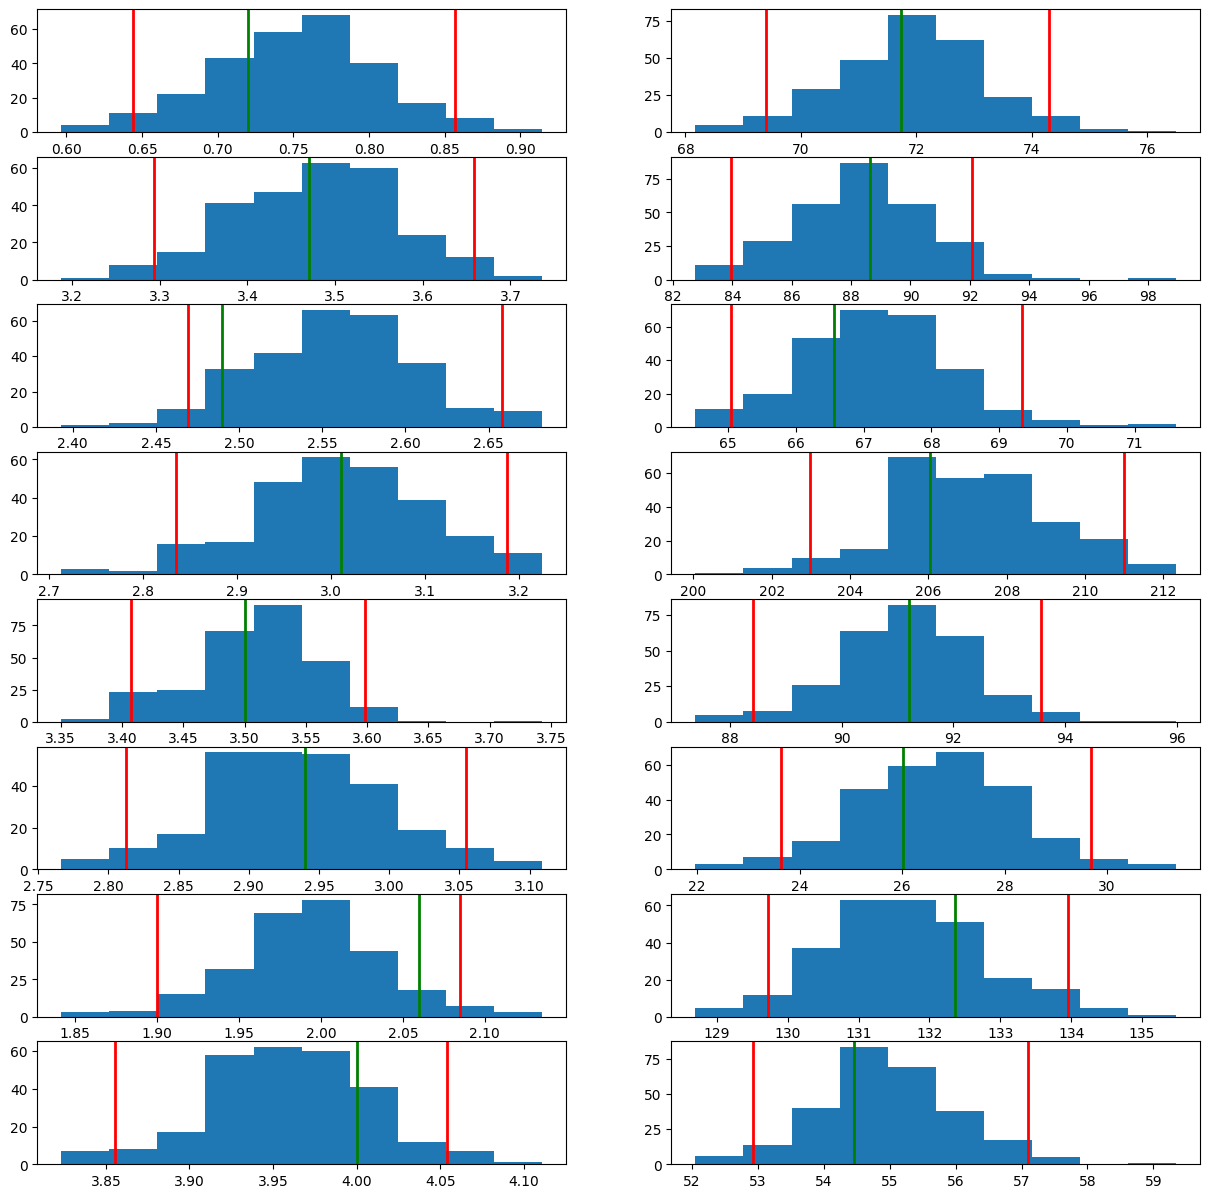

In [74]:
fig, axs = plt.subplots(8, 2,figsize=(15, 15))
# axs = axs.ravel()
# counter = 0
for idx, i in enumerate(random_idx):
    # print(counter)
    truth = y_valid_cur[i,:]
    preds = G_u_test[:, i,:]
    percts = np.percentile(preds, axis = 0, q = (2.5, 97.5))
    lis = percts[0,:]
    uis = percts[1,:]
    
    
    axs[idx, 0].hist(preds[:,0])
    axs[idx, 0].axvline(truth[0], color='green', linewidth=2)
    axs[idx, 0].axvline(lis[0], color='red', linewidth=2)
    axs[idx, 0].axvline(uis[0], color='red', linewidth=2)
    
    axs[idx, 1].hist(preds[:,1])
    axs[idx, 1].axvline(truth[1], color='green', linewidth=2)
    axs[idx, 1].axvline(lis[1], color='red', linewidth=2)
    axs[idx, 1].axvline(uis[1], color='red', linewidth=2)
    
    # counter+=2
    # print(counter)
    
    # plt.show()
plt.savefig('prediction_intervals.png', bbox_inches='tight')

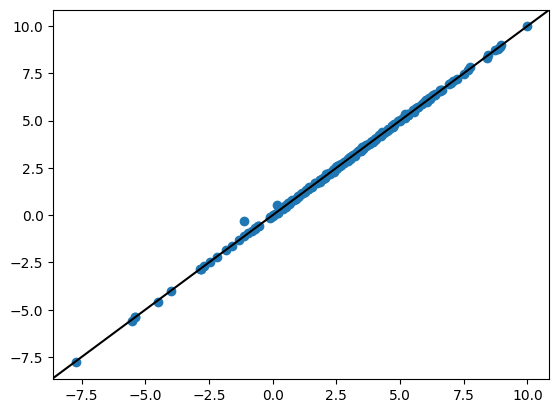

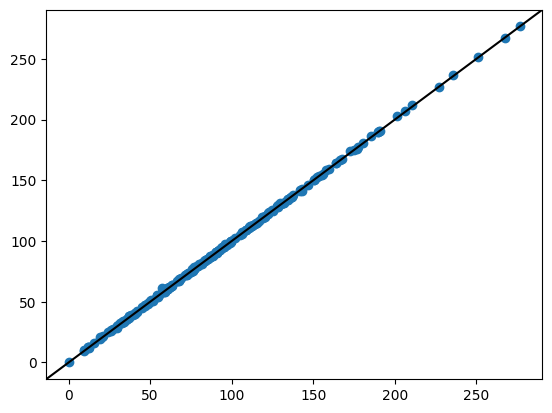

In [75]:
plt.scatter(y_valid_cur[:, 0], averaged_targets_test[:,0])
plt.axline((0,0), slope = 1, c= "black")
plt.show()
plt.scatter(y_valid_cur[:,1], averaged_targets_test[:, 1])
plt.axline((0,0), slope = 1, c= "black")
plt.show()